In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import math
from scipy.fft import fft2, fftshift, ifftshift, ifft2
import nibabel as nib

import torch
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
#from pytorch_msssim import SSIM

Ne pas faire Run All mais run cellule par cellule car on ne veux pas run la cellule d'entraînement car les modèles ont déja été entraînés.

Récupérer les 180 images enregistrées dans les fichiers en format numpy

(180, 64, 64)
Mean: 0.17564063248721856
le min et le max 0.0 -1.0000000542488139
[0.01924842 0.01924842 0.01924841 0.01924835 0.01924777 0.01924493
 0.01926267 0.02046053 0.02373421 0.04584317 0.10842714 0.666419
 0.2934612  0.13554078 0.07225248 0.29313136 0.38590591 0.46306559
 0.45118989 0.4547623  0.49496272 0.44474979 0.41827334 0.41365919
 0.51557277 0.50774623 0.48816489 0.49212038 0.3786096  0.1712598
 0.12244126 0.12354479 0.24792985 0.13028878 0.15383504 0.14936661
 0.40088488 0.4999532  0.54853388 0.4946358  0.51482709 0.40634051
 0.29995488 0.4085377  0.492057   0.43433673 0.3931466  0.42654826
 0.33785022 0.06994855 0.18159828 0.3556299  0.42736417 0.03114184
 0.0306197  0.02287523 0.01940008 0.01925173 0.01924761 0.01924827
 0.0192484  0.01924842 0.01924842 0.01924842]


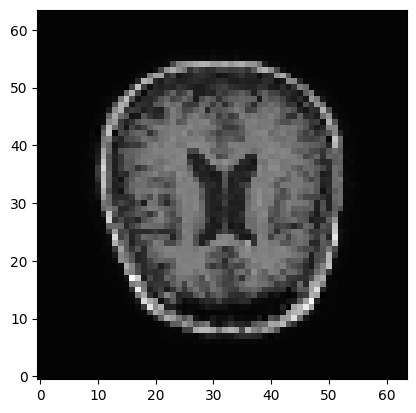

In [ ]:

import os
import numpy as np
from PIL import Image
path_folder = os.getcwd()
#indices_base =[71, 94, 84, 116, 61, 31, 52, 16, 35, 95] # (Masque différent)
#bigy=data_base[indices_base]
data_base = np.load("Data/images_brain_64.npy")#[11:21]
bigy=data_base

print(bigy.shape)
print("Mean:", bigy.mean().item())
print(f"le min et le max {bigy.min()} -{bigy.max()}")
print(bigy[4,32,:],)
# Affichage d’une image
plt.imshow(bigy[4,:,:], cmap="gray", origin="lower")
plt.show()


Afficehr toutes les images du Dataset

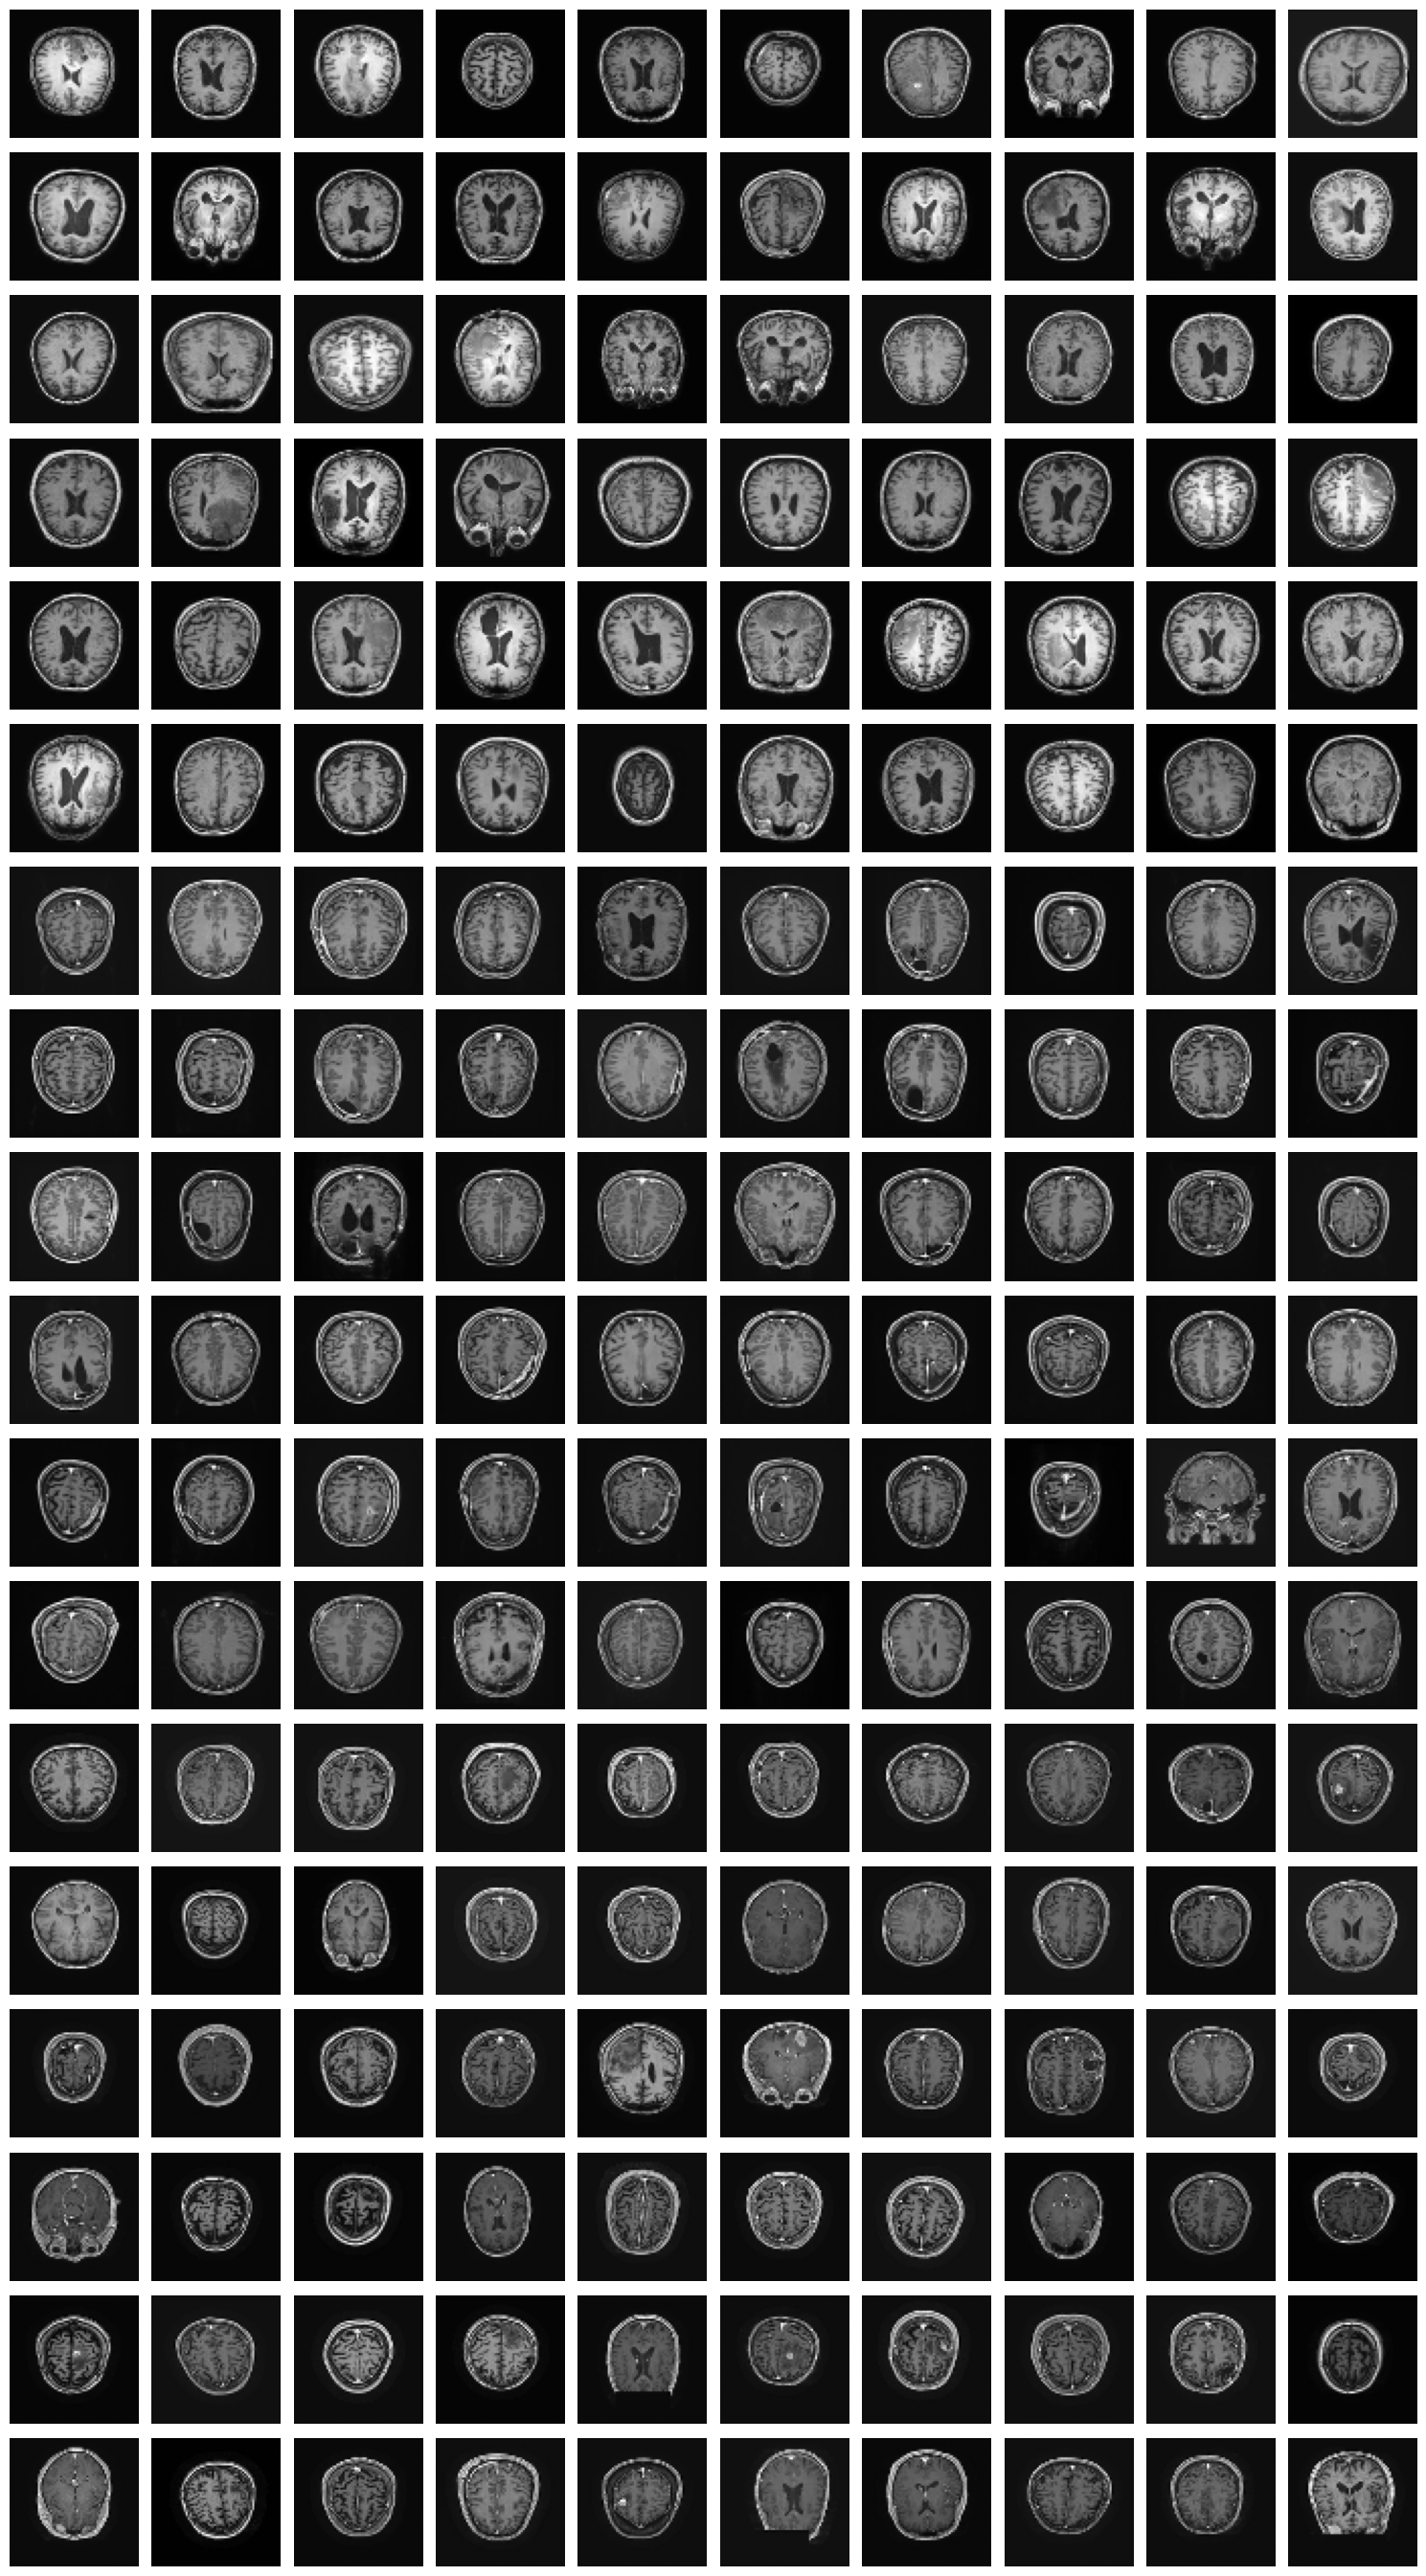

In [ ]:

# n_images=180
# cols = 10  # tu peux ajuster
# rows = math.ceil(n_images / cols)

# # Taille de la figure (ajuster selon ton écran)
# fig, axs = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))

# # Affichage de chaque image
# for i in range(rows * cols):
#     if i < n_images:
#         axs[i // cols, i % cols].imshow(bigy[i,:,:], cmap='gray', origin='lower')
#     axs[i // cols, i % cols].axis('off')

# plt.tight_layout()
# plt.show()

Architecture du modèle Automap

In [33]:
writer=SummaryWriter()
#tensorboard --logdir=runs
dim=64
class Automap(nn.Module):
    def __init__(self):
        super(Automap, self).__init__()

        # Dimensions des images (basées sur vos données)
        self.n_H0 = dim
        self.n_W0 = dim
        n_out = self.n_H0 * self.n_W0 

        # Couche fully connected
        # chaque point d'entrée correspondent à un pixel de sortie
        self.FC1 = nn.Linear(self.n_H0 * self.n_W0 * 2, n_out)  # Input: 116*188*2, Output: 116*188     /Transforme les données brut en un vecteur 1D / chaque point du k-space est connecté à un pixel 
        #1 pixel de l’image affecte	TOUS les points du k-space
        #1 point du k-space	affecte TOUS les pixels de l’image
        self.FC2 = nn.Linear(n_out, n_out)  # Input: 116*188*2, Output: 116*188                         /affine ce vecteur 1D
        self.FC3 = nn.Linear(n_out, n_out) # erreur de code laisser cette ligne ou enlever si cela marche pas
        self.FC_M = (self.n_H0, self.n_W0, 1)  # La forme après FC2, avant la convolution               /Reshape pour passer à la partie CNN du réseau avec une image 2D

        # Convolution
        self.W1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2)  # 64 filtres
        self.W2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)  # 64 filtres
        self.W3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=7, stride=1, padding=3)  # 1 filtre de sortie

        # Dropout
        #self.dropout_fc = nn.Dropout(p=0.3)  # Probabilité à ajuster (0.3 est un bon début)
        #self.dropout_conv = nn.Dropout2d(p=0.3)  # Pour les feature maps
        # Déconvolution (Transposée)
        #self.deconv = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=7, stride=1, padding=3)

    def forward(self,x):
        #print(f"Input shape: {x.shape}")
        #print(type(x))
        
        batch_size= x.size(0)
        x_temp = x.contiguous().reshape(batch_size, dim * dim * 2)  # Redimensionne dynamiquement 
        #print("x_temp", type(x_temp))
        
        # Fully connected layers
        #print("self.FC1", type(self.FC1))

        #tanh réduire les valeurs entre -1 et 1
        FC1_out = F.tanh(self.FC1(x_temp)) # (n_im, n_H0 * n_W0 * 2) -> (n_im, n_H0 * n_W0)
        #FC1_out = self.dropout_fc(FC1_out)  
        #print("FC1_out", type(FC1_out))
        
        FC2_out = F.tanh(self.FC2(FC1_out)) # (n_im, n_H0 * n_W0) -> (n_im, n_H0 * n_W0) 

        # Reshape avant la convolution (pour correspondre à la forme attendue)
        FC_M = FC2_out.contiguous().reshape(batch_size, 1, dim, dim)  # Reshaper FC2 à la forme (batch, 1, 116, 188)

        # Convolution
        #relu enlève les négatifs
        Z1 = self.W1(FC_M) # Input size (n_im, n_H0, n_W0, 1), output size (n_im, n_H0, n_W0, 64)
        CONV1 = F.relu(Z1)

        Z2 = self.W2(CONV1) # Input size (n_im, n_H0, n_W0, 1), output size (n_im, n_H0, n_W0, 64)
        CONV2 = F.relu(Z2)
        #CONV2 = self.dropout_conv(CONV2)  

        # Calculer la perte L1 sur la dernière couche de convolution

        Z3 = self.W3(CONV2)
        CONV3 = Z3

        # Pas de déconvolution à la fin (4, 1, 116, 188)->(4, 116, 188) COMPARER AVEC les images sans canaux
        DECONV = CONV3.squeeze(1)
        #1

        return DECONV  # Retirer la dimension de batch si nécessaire




Fonction qui permet de passer les images dans le domaine spatial aux images dnas le domaine fréquentiel
Fonction qui permet d'appliquer aussi les masques radiaux ou cartésiens
Fonction qui permet aussi de transformer mes tableaux numpy en tensor

In [13]:
#FONCTION AUGMENTE LES DONNES
import torch
from torchvision.transforms.functional import rotate
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset

import torchvision.transforms.functional as TF
from PIL import Image


# Image Rotation

def rotate_subset_images(dataset):
    angles = [0,180]
    rotated_noisy = []
    rotated_clean = []

    for i in range(len(dataset)):
        noisy, clean = dataset[i]  # noisy : [H, W, 2] ; clean : [H, W]

        # Assure-toi qu’ils sont en float32
        noisy = noisy.float()
        clean = clean.float()

        # Pour chaque angle
        for angle in angles:
            # [H, W, 2] → [2, H, W]
            noisy_permuted = noisy.permute(2, 0, 1)
            noisy_rotated = rotate(noisy_permuted, angle)
            # [2, H, W] → [H, W, 2]
            noisy_rotated = noisy_rotated.permute(1, 2, 0)

            clean_rotated = rotate(clean.unsqueeze(0), angle).squeeze(0)

            rotated_noisy.append(noisy_rotated)
            rotated_clean.append(clean_rotated)

    # Empilement final
    noisy_tensor = torch.stack(rotated_noisy)
    clean_tensor = torch.stack(rotated_clean)

    return TensorDataset(noisy_tensor, clean_tensor)

#Fonction K_space

# Effet miroir

def miroir_images(dataset):
    if isinstance(dataset, (torch.utils.data.Subset, torch.utils.data.Dataset)):
        data_list = [dataset[i] for i in range(len(dataset))]
        data_tensor = torch.stack(data_list)
    elif isinstance(dataset, torch.Tensor):
        data_tensor = dataset
    else:
        raise TypeError(f"Type non supporté : {type(dataset)}")

    data_numpy = data_tensor.cpu().numpy() 

    image_clean_miroir=[]
   
    for image in data_numpy:
        # Gérer le cas (1, H, W) -> on squeeze pour avoir (H, W)
        if image.ndim == 3:
            image = image.squeeze()

        # Convertir l’image NumPy vers PIL
        image_pil = Image.fromarray((image * 255).astype(np.uint8))

        # Images miroir
        flip_lr = image_pil.transpose(Image.FLIP_LEFT_RIGHT)
        flip_ud = image_pil.transpose(Image.FLIP_TOP_BOTTOM)

        # Convertir les images miroir et originale en tenseurs normalisés [0, 1]
        image_orig = torch.tensor(np.array(image_pil), dtype=torch.float32) / 255.
        image_lr = torch.tensor(np.array(flip_lr), dtype=torch.float32) / 255.
        image_ud = torch.tensor(np.array(flip_ud), dtype=torch.float32) / 255.

        for img in (image_orig,image_lr,image_ud):
            image_clean_miroir.append(img.unsqueeze(0))  # [H, W] → [1, H, W]

        
        
    
    # Empilement final
    F_tensor = torch.tensor(np.stack(image_clean_miroir), dtype=torch.float32) 

    return F_tensor



def FourierTransformMask(data, rotation=10):
    # Si data est un Subset ou Dataset, on extrait les données
    if isinstance(data, (torch.utils.data.Subset, torch.utils.data.Dataset)):
        data_list = [data[i] for i in range(len(data))]
        data_tensor = torch.stack(data_list)
    elif isinstance(data, torch.Tensor):
        data_tensor = data
        
    else:
        raise TypeError(f"Type non supporté : {type(data)}")

    # Conversion vers NumPy pour le traitement FFT
    data_numpy = data_tensor.cpu().numpy()  # (N, C, H, W) ou (N, H, W)
    

    F_shifted_mask_with_images = []

    for image in data_numpy:
        # Gérer le cas (1, H, W) -> on squeeze pour avoir (H, W)
        if image.ndim == 3:
            image = image.squeeze()

        FT1 = fft2(image)
        total_energy = np.sum(np.abs(FT1))
        FT1 = FT1 / (total_energy + 1e-8)

        F_shifted = fftshift(FT1)
        rows, cols = F_shifted.shape
        crow, ccol = rows // 2, cols // 2

        # Mask radiale
        mask = np.zeros((rows, cols), dtype=np.float32)
        for angle_deg in np.arange(0, 180, rotation):
            angle_rad = np.deg2rad(angle_deg)
            dx = np.cos(angle_rad)
            dy = np.sin(angle_rad)

            for r in range(-max(rows, cols), max(rows, cols)):
                x = int(crow + r * dx)
                y = int(ccol + r * dy)
                if 0 <= x < rows and 0 <= y < cols:
                    mask[x, y] = 1
        
        # Mask cartésien
        mask1 = np.zeros((rows, cols), dtype=np.float32)
        for x in range(0,rows,1):
            if (crow - 5 < x < crow + 5):
                mask1[x, :] = 1
            elif (crow - 13 < x < crow - 10):
                mask1[x, :] = 1
            elif (crow + 10 < x < crow + 13):
                mask1[x, :] = 1    
            elif (crow + 20 < x < crow + 22):
                mask1[x, :] = 1    
            elif (crow - 23 < x < crow - 20):
                mask1[x, :] = 1
            # if (crow - 7 < x < crow + 7):
            #     mask1[x, :] = 1
            # elif (crow - 15 < x < crow - 10):
            #     mask1[x, :] = 1
            # elif (crow + 10 < x < crow + 15):
            #     mask1[x, :] = 1    
            # elif (crow + 20 < x < crow + 25):
            #     mask1[x, :] = 1    
            # elif (crow - 25 < x < crow - 20):
            #     mask1[x, :] = 1
            # elif (crow + 30 < x < crow + 33):
            #     mask1[x, :] = 1    
            # elif (crow - 33 < x < crow - 30):
            #     mask1[x, :] = 1
            # if (crow - 15 < x < crow + 15):
            #     mask1[x, :] = 1   
            # elif (crow + 18 < x < crow + 25):
            #     mask1[x, :] = 1    
            # elif (crow - 25 < x < crow - 18):
            #     mask1[x, :] = 1
            # elif (crow + 30 < x < crow + 35):
            #     mask1[x, :] = 1    
            # elif (crow - 35 < x < crow - 30):
            #     mask1[x, :] = 1
            # elif (crow + 40 < x < crow + 45):
            #     mask1[x, :] = 1    
            # elif (crow - 45 < x < crow - 40):
            #     mask1[x, :] = 1

        F_masked = F_shifted * mask
        real_part = np.real(F_masked)
        imag_part = np.imag(F_masked)
        F_masked_complex = np.stack((real_part, imag_part), axis=-1)  # (H, W, 2)
        F_shifted_mask_with_images.append(F_masked_complex)

    F_tensor = torch.tensor(np.stack(F_shifted_mask_with_images), dtype=torch.float32)  # (N, H, W, 2)
    #F_tensor=F_tensor.permute(1,2,0) #(N,2, H, W)
    data_tensor= data_tensor.squeeze(1)
    return TensorDataset(F_tensor, data_tensor)
    #return TensorDataset(data_tensor, F_tensor)


Normalisation de mes images et partition des données avec un seed de 1

Le cinquième bloc consiste à appliquer la transformée de Fourier et le masque de sous-échantillonnage à mes jeux de données d’entraînement, de validation et de test. Les images sont stockées dans trois variables appelées trainLoader, validationLoader et testLoader. Chaque loader contient deux types d’images : les images cibles, qui correspondent aux images de référence dans le domaine spatial, et les images d’entrée, qui sont les images sous-échantillonnées dans le k-space censé représenter les images en sorties d’IRM.

In [15]:


# Dataset personnalisé
class NoisyImageDataset(Dataset):
    def __init__(self, clean_images, transform=None):
        self.clean_images = clean_images
        #self.noisy_images = noisy_images
        self.transform = transform

    def __len__(self):
        return len(self.clean_images)

    def __getitem__(self, idx):
        clean = self.clean_images[idx]# Pour une image
        
        
        if self.transform:
            clean = self.transform(clean)

        return clean  # entrée = bruitée, cible = propre

# Transfo pour passer en tenseur [0,1]
transform = transforms.Compose([
    transforms.ToTensor(), #Pas nombre à virgule
   
])

# Création du Dataset
train_dataset = NoisyImageDataset(bigy,transform=transform)
batch_size = 16


dataset_size = len(train_dataset)
# Calcul des tailles
train_size = int(0.8* dataset_size)
val_size = int(0.5*(dataset_size - train_size))
test_size = dataset_size - train_size - val_size  # Le reste

# k=[1,2,3,4,5]
# dict_seed= {}

# for i in k:
#     seed=i
seed=1
torch.manual_seed(seed) 
generator = torch.Generator().manual_seed(seed)
# Split direct en 3 parties
train_dataset_split, validation_dataset_split, test_dataset_split = random_split(
    train_dataset,
    [train_size, val_size, test_size],
    generator=generator
)

train_indices = train_dataset_split.indices
val_indices = validation_dataset_split.indices
test_indices = test_dataset_split.indices  



# Appliquer les miroirs
#train_images_tensor = miroir_images(train_dataset_split)
#print(f"Nombre d'images d'entraînement : {len(train_images_tensor)}")
#validation_images_tensor=miroir_images(validation_dataset_split)
#print(f"Nombre d'images d'entraînement : {len(validation_images_tensor)}")
#test_images_tensor=miroir_images(test_dataset_split)
#print(f"Nombre d'images d'entraînement : {len(test_images_tensor)}")

train_dataset_split_mask=FourierTransformMask(train_dataset_split,rotation=10)
validation_dataset_split_mask=FourierTransformMask(validation_dataset_split,rotation=10)
test_dataset_split_mask=FourierTransformMask(test_dataset_split,rotation=10)


# Création des DataLoaders 
train_loader = DataLoader(train_dataset_split_mask, batch_size=batch_size, shuffle=True) # shuffle=True permet que à chaque epoch se soit pas le meme groupe de 16 images qui est pris ensemble
validation_loader = DataLoader(validation_dataset_split_mask, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_split_mask, batch_size=batch_size, shuffle=False)

#if seed==1 or seed==2:
print("seed",seed)

print(f"Nombre d'images d'entraînement : {len(train_dataset_split_mask)}")
print(train_dataset_split.indices)
print(f"Nombre d'images de validation : {len(validation_dataset_split_mask)}")
print(validation_dataset_split.indices)
print(f"Nombre d'images de test : {len(test_dataset_split_mask)}")
print(test_dataset_split.indices)

for batch_noisy, batch_clean in train_loader:
    print(f"Plage des valeurs des images d'entrée (bruitées) : {batch_noisy.min().item()} - {batch_noisy.max().item()}")
    print(f"Plage des valeurs des images cibles (propres) : {batch_clean.min().item()} - {batch_clean.max().item()}")
    print(f"F_bruitee {batch_noisy.shape}")
    print(f"image_base {batch_clean.shape}")
    break

# dict_seed[seed] = {
#     "train": train_loader,
#     "validation" : validation_loader,
#     "test": test_loader,
#     "indices":{
#         "train": train_indices,
#         "validation" : val_indices,
#         "test": test_indices

#     }
# }





seed 1
Nombre d'images d'entraînement : 144
[85, 62, 8, 107, 51, 18, 89, 2, 4, 9, 128, 115, 136, 146, 57, 120, 13, 161, 10, 55, 50, 174, 152, 40, 171, 36, 12, 125, 17, 26, 98, 141, 179, 81, 41, 113, 3, 138, 37, 101, 0, 75, 28, 53, 24, 60, 164, 127, 137, 91, 154, 38, 45, 134, 63, 153, 32, 43, 117, 114, 106, 156, 173, 77, 48, 178, 23, 69, 22, 112, 129, 86, 46, 172, 73, 19, 33, 139, 131, 78, 111, 108, 104, 162, 163, 66, 143, 29, 110, 47, 140, 149, 1, 59, 92, 83, 123, 99, 170, 133, 34, 158, 100, 132, 72, 44, 15, 7, 96, 64, 97, 121, 58, 147, 88, 74, 126, 118, 122, 27, 11, 25, 93, 39, 157, 82, 169, 160, 87, 168, 56, 148, 70, 42, 5, 76, 144, 90, 105, 165, 80, 124, 21, 130]
Nombre d'images de validation : 18
[14, 20, 142, 67, 68, 49, 54, 167, 103, 159, 119, 155, 166, 151, 177, 65, 175, 176]
Nombre d'images de test : 18
[71, 94, 84, 116, 61, 31, 52, 16, 35, 95, 102, 30, 135, 79, 6, 150, 109, 145]
Plage des valeurs des images d'entrée (bruitées) : -0.01770554669201374 - 0.03936714306473732
Plage

Initialiser les poids avec formule xavier pour pas avoir de poids random

In [10]:
# Fonction pour initialiser les poids avec Xavier -> Faire en sorte que tous le spoids ne soient pas random 
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight)  # Xavier Initialisation
        if m.bias is not None:
            nn.init.zeros_(m.bias)  # Initialisation des biais à 0

Initialisation des paramètre et hyper-paramètre pour l'entraînenement (Loss, critère d'arrêt)

In [17]:
epoch = 0
cpt = 0
best_loss = 100000
maxwhile=50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
model = Automap().to(device)

criterion_mse = nn.MSELoss()
#criterion_ssim = SSIM(win_size=11, win_sigma=1.5, data_range=1.0, size_average=True, channel=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


False



Entraînement du modèle (enregistrement des poids dans un fichier pth)
Ne pas compiler sauf si on veut entraîner un nouveau modèle

Le sixième bloc correspond à la phase d’entraînement. C’est à ce moment que le modèle apprend à partir des jeux de données d’entraînement et de validation. Pour suivre l’évolution de l’entraînement, j’affiche à chaque itération la valeur de la loss sur le jeu d’entraînement ainsi que sur le jeu de validation. De plus, pour chaque epoch, j’affiche que le modèle a été sauvegardé. En effet, à chaque epoch les poids sont enregistrés dans un fichier pth afin de pouvoir tester le modèle par la suite sur le jeu de données de test.

In [ ]:
#Cross validation
#for seed in dict_seed:
print(seed)
while(True):
#for epoch in range(epochs):
    model.train()
    running_loss = 0.0 
    for batch_input, batch_target in train_loader:
        #print(f"batch_input {batch_input.shape}")
        #print(f"batch_target {batch_target.shape}")
        
        batch_input = batch_input.to(device).float()
        #print(f"Entree du model (bruitées) : {batch_input.min().item()} - {batch_input.max().item()}")
        batch_target = batch_target.to(device).float()  
        #print(f"valeur cible du model (reference) : {batch_target.min().item()} - {batch_target.max().item()}")

        #print("type batch_input :", type(batch_input))
        
        #print("type batch_target:", type(batch_target))  

        outputs = model(batch_input)
        #print('outputs',outputs.shape)
        #print('batch_target',batch_target.shape)
        #print(f" Sortie du model : {outputs.min().item()} - {outputs.max().item()}")
        #ssim_loss = 1 - ssim(outputs, batch_target)
        loss_mse = criterion_mse(outputs, batch_target)
        l1_penalty = sum(torch.sum(torch.abs(param)) for param in model.W2.parameters())
        loss = loss_mse + 0.0001 * l1_penalty
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    writer.add_scalar(f"Loss/train{seed}", avg_train_loss, epoch)

    model.eval() #  Calcul la perte pour voir comment le modèle se débrouille -> C'est l'examen réel.
    val_loss = 0.0
    val_loss0=0.0
    with torch.no_grad(): #torch.no_grad() pas de rétropropagation
        print("val_loss0",val_loss0)
        for batch_input, batch_target in validation_loader:
            batch_input = batch_input.to(device).float()
            batch_target = batch_target.to(device).float()

            outputs = model(batch_input)
            loss_mse = criterion_mse(outputs, batch_target)
            loss = loss_mse
        
            val_loss += loss.item()   

    avg_val_loss = val_loss / len(validation_loader)
    writer.add_scalar(f"Loss/val{seed}", avg_val_loss, epoch)    
    if avg_val_loss < best_loss:
        cpt = 0
        
        best_loss = avg_val_loss
        path_model = path_folder + f"/Automap_image_pelvis_cartesien_64_10_LR_bande0125.pth"
        
        torch.save(model.state_dict(), path_model)
        print(f" Modèle sauvegardé sous  {path_model}")
    else:
        cpt += 1
                
    if cpt == maxwhile:  
        break           
            
    print(f" Époque [{epoch+1}] — Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    epoch+=1
writer.close() #tensorboard


1
val_loss0 0.10587727651000023
 Modèle sauvegardé sous  c:\Users\rapha\OneDrive\Bureau\Stage_Ing4/Automap_image_pelvis_cartesien_64_10_LR_bande0125.pth
 Époque [1] — Train Loss: 0.257106, Val Loss: 0.134361
val_loss0 0.09531665220856667
 Modèle sauvegardé sous  c:\Users\rapha\OneDrive\Bureau\Stage_Ing4/Automap_image_pelvis_cartesien_64_10_LR_bande0125.pth
 Époque [2] — Train Loss: 0.246746, Val Loss: 0.125664
val_loss0 0.08624759316444397
 Modèle sauvegardé sous  c:\Users\rapha\OneDrive\Bureau\Stage_Ing4/Automap_image_pelvis_cartesien_64_10_LR_bande0125.pth
 Époque [3] — Train Loss: 0.237246, Val Loss: 0.117749
val_loss0 0.07857998833060265
 Modèle sauvegardé sous  c:\Users\rapha\OneDrive\Bureau\Stage_Ing4/Automap_image_pelvis_cartesien_64_10_LR_bande0125.pth
 Époque [4] — Train Loss: 0.228533, Val Loss: 0.110548
val_loss0 0.07225869223475456
 Modèle sauvegardé sous  c:\Users\rapha\OneDrive\Bureau\Stage_Ing4/Automap_image_pelvis_cartesien_64_10_LR_bande0125.pth
 Époque [5] — Train Los

Code de l'entraînement initial avant cross validation/ FT

In [20]:
#Pas Cross validation
'''epoch = 0
cpt = 0
best_loss = 100000
maxwhile=10

while(True):
#for epoch in range(epochs):
    model.train()
    running_loss = 0.0 
    for batch_input, batch_target in train_loader:
        #print(f"batch_input {batch_input.shape}")
        #print(f"batch_target {batch_target.shape}")
        
        batch_input = batch_input.to(device).float()
        #print(f"Entree du model (bruitées) : {batch_input.min().item()} - {batch_input.max().item()}")
        batch_target = batch_target.to(device).float()  
        #print(f"valeur cible du model (reference) : {batch_target.min().item()} - {batch_target.max().item()}")

        #print("type batch_input :", type(batch_input))
        
        #print("type batch_target:", type(batch_target))  

        outputs = model(batch_input)
        #print('outputs',outputs.shape)
        #print('batch_target',batch_target.shape)
        #print(f" Sortie du model : {outputs.min().item()} - {outputs.max().item()}")
        #ssim_loss = 1 - ssim(outputs, batch_target)
        loss_mse = criterion_mse(outputs, batch_target)
        l1_penalty = sum(torch.sum(torch.abs(param)) for param in model.W2.parameters())
        loss = loss_mse + 0.0001 * l1_penalty
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    writer.add_scalar("Loss/train", avg_train_loss, epoch)

    model.eval() #  Calcul la perte pour voir comment le modèle se débrouille -> C'est l'examen réel.
    val_loss = 0.0
    with torch.no_grad(): #torch.no_grad() pas de rétropropagation
        for batch_input, batch_target in validation_loader:
            batch_input = batch_input.to(device).float()
            batch_target = batch_target.to(device).float()

                    
            outputs = model(batch_input)
            loss_mse = criterion_mse(outputs, batch_target)
            loss = loss_mse
        
            val_loss += loss.item()   

    avg_val_loss = val_loss / len(validation_loader)
    writer.add_scalar("Loss/val", avg_val_loss, epoch)    
    if avg_val_loss < best_loss:
        cpt = 0
          
        best_loss = avg_val_loss

        path_model = path_folder + "/Automap_image_brain_64_test"
        #torch.save({
            #'epoch': epoch,
            #'model_state_dict': model.state_dict(),
            #'optimizer_state_dict': optimizer.state_dict(),
            #'best_loss': best_loss
            
        #}, path_model)
        torch.save(model.state_dict(), path_model)
        print(f" Modèle sauvegardé sous  {path_model}")
    else:
        cpt += 1
                
    if cpt == maxwhile:        
        break           
            
    print(f" Époque [{epoch+1}] — Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    epoch+=1
writer.close() #tensorboard

'''


'epoch = 0\ncpt = 0\nbest_loss = 100000\nmaxwhile=10\n\nwhile(True):\n#for epoch in range(epochs):\n    model.train()\n    running_loss = 0.0 \n    for batch_input, batch_target in train_loader:\n        #print(f"batch_input {batch_input.shape}")\n        #print(f"batch_target {batch_target.shape}")\n        \n        batch_input = batch_input.to(device).float()\n        #print(f"Entree du model (bruitées) : {batch_input.min().item()} - {batch_input.max().item()}")\n        batch_target = batch_target.to(device).float()  \n        #print(f"valeur cible du model (reference) : {batch_target.min().item()} - {batch_target.max().item()}")\n\n        #print("type batch_input :", type(batch_input))\n        \n        #print("type batch_target:", type(batch_target))  \n\n        outputs = model(batch_input)\n        #print(\'outputs\',outputs.shape)\n        #print(\'batch_target\',batch_target.shape)\n        #print(f" Sortie du model : {outputs.min().item()} - {outputs.max().item()}")\n     

Importer des images test si on veut tester avec d'autre image que celles qui sont dans TestLoader

(8, 64, 64)
Mean: 0.17843913869081307
le min et le max 0.0 -1.000000052762211
[0.03755273 0.03755273 0.03755274 0.03755272 0.03755207 0.03754801
 0.03756916 0.03811296 0.03835674 0.05671749 0.03290264 0.42219873
 0.75950944 0.26994427 0.17534764 0.37466579 0.47389794 0.43665542
 0.49887863 0.49881993 0.44849498 0.43425266 0.43451266 0.45332491
 0.45348932 0.45078692 0.48035786 0.48239866 0.4879246  0.47130855
 0.53568119 0.41018446 0.5099196  0.35330325 0.47150279 0.47828525
 0.48479785 0.55928235 0.55729435 0.57611246 0.56516373 0.55207486
 0.57749547 0.52897739 0.53160945 0.53291266 0.51227471 0.47373414
 0.40308914 0.23016788 0.13411727 0.15620971 0.82578838 0.18623213
 0.0525495  0.04388623 0.03733065 0.03754307 0.03755551 0.03755313
 0.03755274 0.03755273 0.03755273 0.03755273]


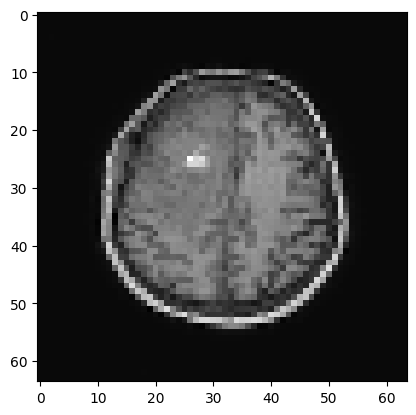

(8, 64, 64)
Plage des valeurs des images d'entrée (bruitées) : 0.0 - 1.000000052762211
torch.Size([8, 64, 64])


In [ ]:
# tester avec Pelvis pour un model entrainer avec des cerveau
indices=[102, 30, 135, 79, 6, 150, 109, 145]


data = np.load("Data/images_brain_64.npy")
bigy_test=data[indices]

print(bigy_test.shape)
print("Mean:", bigy_test.mean().item())
print(f"le min et le max {bigy_test.min()} -{bigy_test.max()}")
print(bigy_test[4,32,:],)
# Affichage d’une image
plt.imshow(bigy_test[4,:,:], cmap="gray")
plt.show()

images_test_normalized = list(bigy_test)

bigy_test = np.stack(images_test_normalized) #Empiler un tableau nunpy
print(bigy_test.shape)
print(f"Plage des valeurs des images d'entrée (bruitées) : {bigy_test.min()} - {bigy_test.max()}")

images_test_normalized_propre=np.array(images_test_normalized)
tensor_images_test_normalized_propre= torch.from_numpy(images_test_normalized_propre)
print(tensor_images_test_normalized_propre.shape)
#tensor_images_test_normalized_propre = tensor_images_test_normalized_propre.unsqueeze(1)




Application des masks et de Fourier pour les images Test que je veux tester

F_shifted.shape: torch.Size([8, 64, 64, 2])
Plage des valeurs des images d'entrée (bruitées) : 0.0 - 1.0
<class 'torch.Tensor'>
F_shifted.shape: torch.Size([8, 64, 64, 2])
Plage des valeurs des images d'entrée (bruitées) : -0.012452845574385462 - 0.03420743016751416


Text(0.5, 1.0, 'tensor_images_test_normalized_propre ')

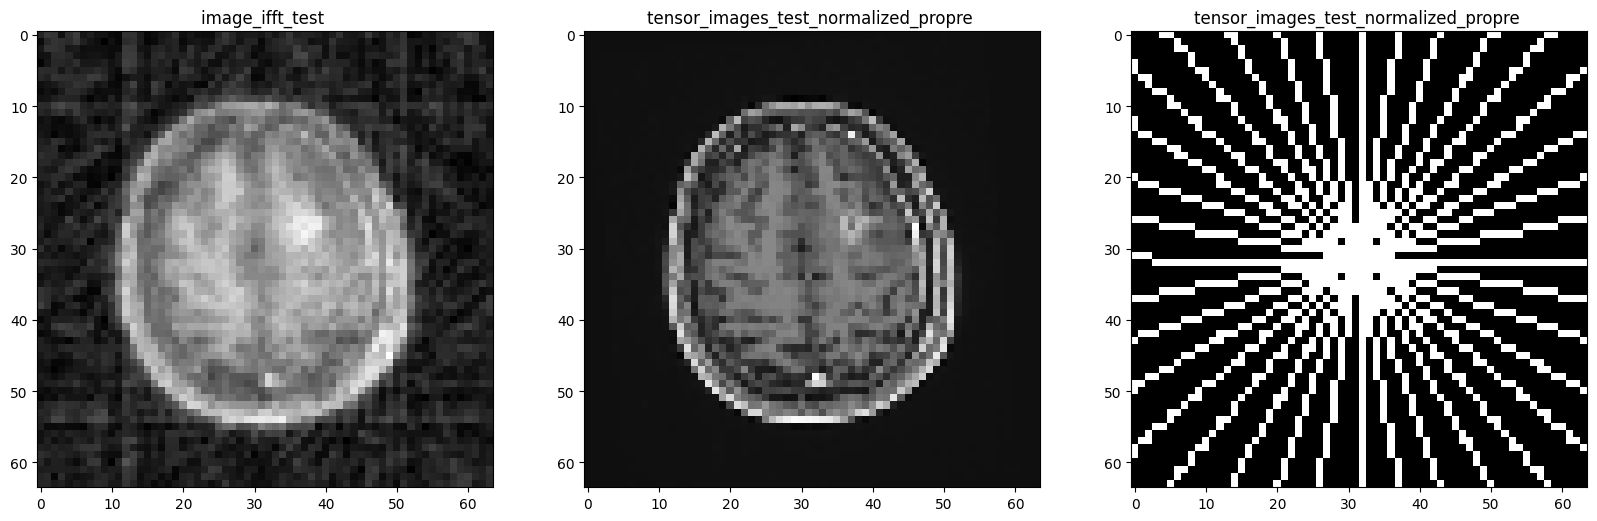

In [21]:
#Modele

import random

F_shifted_mask_test_images = []  # Liste pour stocker les F_shifted de chaque image
F_shifted_mask_test_with_images = [] 

rotation = 10

for image in(images_test_normalized):

    rot=0
    
    FT1_test = fft2(image)
    total_energy = np.sum(np.abs(FT1_test))
    FT1_test = FT1_test / (total_energy + 1e-8)
    F_shifted_test = fftshift(FT1_test)

    rows, cols = F_shifted_test.shape
    crow, ccol = rows // 2, cols // 2

    # Créer un masque directionnel
    #mask1 = np.ones((rows, cols), dtype=np.float32) # Pas de masque car que des 1
    mask0_test = np.zeros((rows, cols), dtype=np.float32)
    for angle_deg in np.arange(0, 180, rotation):  
        angle_rad = np.deg2rad(angle_deg)
        dx = np.cos(angle_rad)
        dy = np.sin(angle_rad)

        for r in range(-max(rows, cols), max(rows, cols)):
            x = int(crow + r * dx)
            y = int(ccol + r * dy)
            
            if 0 <= x < rows and 0 <= y < cols:
                mask0_test[x, y] = 1

    mask1_test = np.zeros((rows, cols), dtype=np.float32)
    for x in range(0,rows,1):
        if (crow - 5 < x < crow + 5):
            mask1_test[x, :] = 1
        elif (crow - 13 < x < crow - 10):
            mask1_test[x, :] = 1
        elif (crow + 10 < x < crow + 13):
            mask1_test[x, :] = 1    
        elif (crow + 20 < x < crow + 22):
            mask1_test[x, :] = 1    
        elif (crow - 23 < x < crow - 20):
            mask1_test[x, :] = 1
        # if (crow - 7 < x < crow + 7):
        #     mask1_test[x, :] = 1
        # elif (crow - 15 < x < crow - 10):
        #     mask1_test[x, :] = 1
        # elif (crow + 10 < x < crow + 15):
        #     mask1_test[x, :] = 1    
        # elif (crow + 20 < x < crow + 25):
        #     mask1_test[x, :] = 1    
        # elif (crow - 25 < x < crow - 20):
        #     mask1_test[x, :] = 1
        # elif (crow + 30 < x < crow + 33):
        #     mask1_test[x, :] = 1    
        # elif (crow - 33 < x < crow - 30):
        #     mask1_test[x, :] = 1
        # if (crow - 15 < x < crow + 15):
        #     mask1_test[x, :] = 1   
        # elif (crow + 18 < x < crow + 25):
        #     mask1_test[x, :] = 1    
        # elif (crow - 25 < x < crow - 18):
        #     mask1_test[x, :] = 1
        # elif (crow + 30 < x < crow + 35):
        #     mask1_test[x, :] = 1    
        # elif (crow - 35 < x < crow - 30):
        #     mask1_test[x, :] = 1
        # elif (crow + 40 < x < crow + 45):
        #     mask1_test[x, :] = 1    
        # elif (crow - 45 < x < crow - 40):
        #     mask1_test[x, :] = 1
        

        

    # Appliquer le masque avec K_space
    F_shifted_mask_test=mask0_test #* F_shifted 
    F_shifted_mask1_test=F_shifted_test * mask0_test
    #Partie réel et imaginaire
    #real_part = np.real(F_shifted_mask)
    #imag_part = np.imag(F_shifted_mask)
    real_part_test = F_shifted_mask_test
    imag_part_test = F_shifted_mask_test

    real_part1_test = np.real(F_shifted_mask1_test)
    imag_part1_test = np.imag(F_shifted_mask1_test)
    F_masked_complex_test = np.stack((real_part_test, imag_part_test), axis=-1)
    F_masked_complex1_test = np.stack((real_part1_test, imag_part1_test), axis=-1)
    # magnitude_spectrum = np.abs(F_shifted_mask)
    F_shifted_mask_test_images.append(F_masked_complex_test)
    F_shifted_mask_test_with_images.append(F_masked_complex1_test)



# MASQUE 2 CANAUX réel et phase
F_mask_test= np.array(F_shifted_mask_test_images)
#F_mask_test = np.transpose(F_mask_test, (0, 3, 1, 2))
tensor_F_mask_test = torch.from_numpy(F_mask_test)
print(f"F_shifted.shape: {tensor_F_mask_test.shape}") 
print(f"Plage des valeurs des images d'entrée (bruitées) : {tensor_F_mask_test.min()} - {tensor_F_mask_test.max()}")


F_mask_test_image= np.array(F_shifted_mask_test_with_images)
#F_mask_test_image = np.transpose(F_mask_test_image, (0, 3, 1, 2))
tensor_F_mask_test_image = torch.from_numpy(F_mask_test_image)
print(type(tensor_F_mask_test_image))
print(f"F_shifted.shape: {tensor_F_mask_test_image.shape}") 
print(f"Plage des valeurs des images d'entrée (bruitées) : {tensor_F_mask_test_image.min()} - {tensor_F_mask_test_image.max()}")


real1_test=tensor_F_mask_test_image[0,:,:,0]
imag1_test=tensor_F_mask_test_image[0,:,:,1]
image_ifft_test=torch.abs(torch.fft.ifft2(torch.fft.ifftshift(real1_test + imag1_test*1j)))

plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
plt.imshow(image_ifft_test, cmap="gray")
plt.title("image_ifft_test ")
plt.subplot(1, 3, 2)
plt.imshow(tensor_images_test_normalized_propre[0,:,:], cmap="gray")
plt.title("tensor_images_test_normalized_propre ")
plt.subplot(1, 3, 3)
plt.imshow(tensor_F_mask_test[0,:,:,0], cmap="gray")
plt.title("tensor_images_test_normalized_propre ")

Inférence :
- Tester avec les images enregistrer dans TestLoader
- Tester avec des images à part

Changer la valeur de i pour afficher les différentes images
Calcul la moyenne et l'écart type de toutes les images test

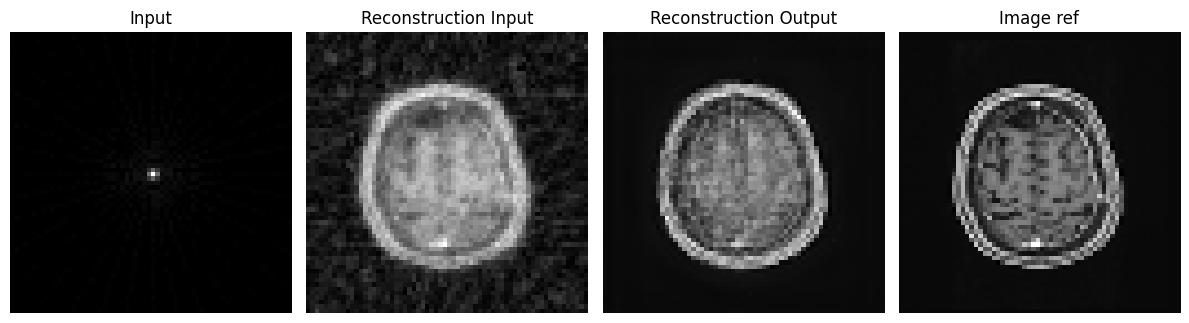

 ifft -> 17.04 dB
 modèle -> 21.86 dB
 ifft -> 15.13 dB
 modèle -> 22.78 dB
 ifft -> 20.43 dB
 modèle -> 20.04 dB
 ifft -> 15.06 dB
 modèle -> 21.77 dB
 ifft -> 15.11 dB
 modèle -> 20.23 dB
 ifft -> 15.40 dB
 modèle -> 20.80 dB
 ifft -> 16.34 dB
 modèle -> 19.85 dB
 ifft -> 21.59 dB
 modèle -> 20.11 dB
 ifft -> 16.10 dB
 modèle -> 19.57 dB
 ifft -> 15.30 dB
 modèle -> 21.53 dB
 ifft -> 15.99 dB
 modèle -> 20.02 dB
 ifft -> 16.06 dB
 modèle -> 20.04 dB
 ifft -> 15.22 dB
 modèle -> 23.47 dB
 ifft -> 19.47 dB
 modèle -> 20.16 dB
 ifft -> 17.61 dB
 modèle -> 22.58 dB
 ifft -> 17.06 dB
 modèle -> 21.15 dB
 ifft -> 15.62 dB
 modèle -> 19.94 dB
 ifft -> 18.12 dB
 modèle -> 19.14 dB
PSNR
 Entrée -> 16.81 dB
 Sortie -> 20.84 dB
 ecart-type Entrée -> 1.95 dB
 ecart-type Sortie -> 1.23 dB


In [36]:
#from skimage.metrics import structural_similarity as ssim
#import piq

# 1. Recréer le modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Automap().to(device)

moyenne_PSNR_seed_entre=[]
moyenne_PSNR_seed_sortie=[]
moyenne_ecart_type_seed_entre=[]
moyenne_ecart_type_seed_sortie=[]

# 2. Charger les poids
#for seed in dict_seed:
path_model = path_folder + f"/Automap/Automap_image_brain_64_seed_1.pth"
model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu')))
model.eval()

input_imgs_liste=[]
target_imgs_liste=[]

with torch.no_grad(): #Désactive les gradients car pas de back propagation 
    for input_imgs,target_imgs in test_loader:
    # ##input_imgs, target_imgs = next(iter(dict_seed[seed]["test"])) # 16 premières images pour mon batchsize
        input_imgs = input_imgs.to(device).float()
        target_imgs = target_imgs.to(device).float()
        input_imgs_liste.append(input_imgs)
        target_imgs_liste.append(target_imgs)
    

    input_imgs = torch.cat(input_imgs_liste, dim=0)
    target_imgs = torch.cat(target_imgs_liste, dim=0)

    # input_imgs = tensor_F_mask_test_image.to(device).float()
    # target_imgs = tensor_images_test_normalized_propre.to(device).float()

    reconstructed = model(input_imgs)

    index=input_imgs.shape[0]
    #print(index)

    i = 0
    
    #print("input_imgs[i] shape:", input_imgs[i].shape)
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    #print(input_imgs[i].shape)
    real1=input_imgs[i,:,:,0]
    imag1=input_imgs[i,:,:,1]

    complex_kspace = real1 + 1j * imag1
    #print("complex_kspace", complex_kspace.shape, complex_kspace.dtype)

    image_ifft = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(real1 + imag1*1j)))
    #print('ifft',image_ifft.shape)
    
    amplitude = torch.sqrt(real1**2 + imag1**2)
    #magnitude_spectrum=torch.log(amplitude + 1)

    #print(type( amplitude))
    axs[0].imshow(amplitude.squeeze().cpu(), cmap='gray')
    axs[0].set_title(f"Input" )
    axs[1].imshow(image_ifft.squeeze().cpu(), cmap='gray')
    axs[1].set_title(f"Reconstruction Input")
    axs[2].imshow(reconstructed[i].squeeze().cpu(), cmap='gray')
    axs[2].set_title(f"Reconstruction Output")
    axs[3].imshow(target_imgs[i].squeeze().cpu(), cmap='gray')
    axs[3].set_title(f"Image ref")


    test_ifft = (image_ifft- torch.min(image_ifft))/(torch.max(image_ifft)-torch.min(image_ifft))
    #print('ifft',image_ifft.shape)
    #print('target',target_imgs[i].shape)
    
    mse1 = torch.mean((test_ifft - target_imgs[i]) ** 2)
    psnr_value1 = 10 * torch.log10(1.0**2 / mse1)
    #print(f" PSNR sur l'image d'entrée : {psnr_value1:.2f} dB")   

    # Calculer la MSE (Mean Squared Error)
    mse2 = torch.mean((reconstructed[i] - target_imgs[i])** 2)
    psnr_value2 = 10 * torch.log10(1.0**2 / mse2)
    #print(f" PSNR sur l'image de sortie du modèle: {psnr_value2:.2f} dB")
    
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


    psnr_somme1=0
    psnr_somme2=0

    liste_psnr_values1 = []
    #image reconstruite
    liste_psnr_values2 = []

    for i in range (index):
        real = input_imgs[i, :, :, 0]
        imag = input_imgs[i, :, :, 1]
        complex_kspace = real + 1j * imag

        # Reconstruction par ifft
        image_ifft = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(complex_kspace)))
        # Normalisation individuelle
        test1_ifft = (image_ifft - torch.min(image_ifft)) / (torch.max(image_ifft) - torch.min(image_ifft))

        
        mse1 = torch.mean((test1_ifft - target_imgs[i]) ** 2)
        psnr_value1 = 10 * torch.log10(1.0 **2/ mse1)
        liste_psnr_values1.append(psnr_value1)
        print(f" ifft -> {psnr_value1:.2f} dB")   
        
        # Calculer la MSE/PSNR (Mean Squared Error)
        mse2 = torch.mean((target_imgs[i] - reconstructed[i])** 2)
        psnr_value2 = 10 * torch.log10(1.0**2 / mse2)
        liste_psnr_values2.append(psnr_value2)
        print(f" modèle -> {psnr_value2:.2f} dB")    
        
    # Conversion en tenseur pour calculs statistiques
    psnr_values_input = torch.tensor(liste_psnr_values1)
    psnr_values_output = torch.tensor(liste_psnr_values2)

    #Moyenne PSNR
    PNSR_entre=torch.mean(psnr_values_input)
    PSNR_sortie=torch.mean(psnr_values_output)

    #Ecart_type PSNR
    ecart_type_entre=torch.std(psnr_values_input)
    ecart_type_sortie=torch.std(psnr_values_output)

    print("PSNR")  
    print(f" Entrée -> {PNSR_entre:.2f} dB")    
    moyenne_PSNR_seed_entre.append(PNSR_entre)   
    print(f" Sortie -> {PSNR_sortie:.2f} dB") 
    moyenne_PSNR_seed_sortie.append(PSNR_sortie)   
    print(f" ecart-type Entrée -> {ecart_type_entre:.2f} dB") 
    moyenne_ecart_type_seed_entre.append(ecart_type_entre)     
    print(f" ecart-type Sortie -> {ecart_type_sortie:.2f} dB")
    moyenne_ecart_type_seed_sortie.append(ecart_type_sortie)  







    

In [35]:
# Entree
moyenne_PSNR_entree=0
for m in moyenne_PSNR_seed_entre:
    moyenne_PSNR_entree+=m
    
print(f"Moyenne_PSNR_entree: {moyenne_PSNR_entree/5}")
F_moyenne_PSNR_seed_entree=torch.tensor(moyenne_PSNR_seed_entre)
ecart_type_entre_PSNR_entree=torch.std(F_moyenne_PSNR_seed_entree)
print(f"Ecart-type: {ecart_type_entre_PSNR_entree}")

# Sortie
moyenne_PSNR_sortie=0
for m in moyenne_PSNR_seed_sortie:
    #print(m)
    moyenne_PSNR_sortie+=m
    
print(f"Moyenne_PSNR_sortie: {moyenne_PSNR_sortie/5}")
F_moyenne_PSNR_seed_sortie=torch.tensor(moyenne_PSNR_seed_sortie)
ecart_type_entre_PSNR_sortie=torch.std(F_moyenne_PSNR_seed_sortie)
print(f"Ecart-type: {ecart_type_entre_PSNR_sortie}")

Moyenne_PSNR_entree: 3.362683057785034
Ecart-type: nan
Moyenne_PSNR_sortie: 4.167081832885742
Ecart-type: nan


C:\Users\rapha\AppData\Local\Temp\ipykernel_2476\1073275032.py:8: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  ecart_type_entre_PSNR_entree=torch.std(F_moyenne_PSNR_seed_entree)
C:\Users\rapha\AppData\Local\Temp\ipykernel_2476\1073275032.py:19: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  ecart_type_entre_PSNR_sortie=torch.std(F_moyenne_PSNR_seed_sortie)
